## Final Project Submission

Please fill out:
* Student name: Stephen Nderitu Waweru
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Film Industry Exploratory Data Analysis

## Context
To help a new film studio navigate the competitive movie industry, we are charged with exploring what types of films are currently doing the best at the box office. We must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

This includes examining ratings, budgets (production and marketing), genres, persons (directors & actors attatched to the film) and the audiences preferences. By understanding what is successful, the studio can make informed decisions about the types to develop, ensuring they alight with market demands and maximize profitability.

The three buisness questions I seek to answer in this analysis are:
1. What Genres Are Most Profitable?
2. Does Release Date Influence Opening Weekend Box Office Success?
3. Which directors have the highest success rate?

## Data
I'll be using two datasets and one database;
1. im.db from the International Movies Data Base website (link: https://www.imdb.com/)
2. tn.movie_budgets.csv.gz from The Numbers website (link: https://www.the-numbers.com/)
3. bom.movie_gross.csv.gz from Box Office Mojo website (link: https://www.boxofficemojo.com/)


In [42]:
# Loading relevant libraries and modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


In [43]:
# Loading the data and databases
box_mojo_df = pd.read_csv('bom.movie_gross.csv.gz')
the_numbers_df = pd.read_csv('tn.movie_budgets.csv.gz')
imdb_conn = sqlite3.connect('im.db') # Creates a connection to the database
cursor = imdb_conn.cursor() #create cursor

## Look at the Columns and Details of The Data

In [45]:
# A quick peek at the database schema
# Define the queries and their corresponding table names
queries = [
    ("This is the persons table contents", "SELECT * FROM persons LIMIT 10;"),
    ("This is the movie ratings table contents", "SELECT * FROM movie_ratings LIMIT 10;"),
    ("This is the movie basics table contents", "SELECT * FROM movie_basics LIMIT 10;"),
    ("This is the movie akas table contents", "SELECT * FROM movie_akas LIMIT 10;"),
    ("This is the principals table contents", "SELECT * FROM principals LIMIT 10;")]

# Execute the queries and print the results
for message, query in queries:
    print(message)
    cursor.execute(query)
    rows = cursor.fetchall()
    print(rows)

This is the persons table contents
[('nm0061671', 'Mary Ellen Bauder', None, None, 'miscellaneous,production_manager,producer'), ('nm0061865', 'Joseph Bauer', None, None, 'composer,music_department,sound_department'), ('nm0062070', 'Bruce Baum', None, None, 'miscellaneous,actor,writer'), ('nm0062195', 'Axel Baumann', None, None, 'camera_department,cinematographer,art_department'), ('nm0062798', 'Pete Baxter', None, None, 'production_designer,art_department,set_decorator'), ('nm0062879', 'Ruel S. Bayani', None, None, 'director,production_manager,miscellaneous'), ('nm0063198', 'Bayou', None, None, 'actor'), ('nm0063432', 'Stevie Be-Zet', None, None, 'composer,soundtrack'), ('nm0063618', 'Jeff Beal', 1963.0, None, 'composer,music_department,soundtrack'), ('nm0063750', 'Lindsay Beamish', None, None, 'actress,miscellaneous')]
This is the movie ratings table contents
[('tt10356526', 8.3, 31), ('tt10384606', 8.9, 559), ('tt1042974', 6.4, 20), ('tt1043726', 4.2, 50352), ('tt1060240', 6.5, 21),

In [46]:
box_mojo_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [47]:
the_numbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [48]:
the_numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [49]:
box_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


# Data Preparation

## Drop null values and create new columns

The foreign gross from the box_mojo dataset is missing over 1000 values. To mitigate this we'll drop the column and use the_numbers_df dataset to create a column with just the foreign gross as worldwide gross is a sum of foreign and domestic as implied in thier website glossary (https://www.the-numbers.com/glossary).

In [52]:
box_mojo_df.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [53]:
box_mojo_df = box_mojo_df.drop('foreign_gross', axis=1)

In [54]:
# Remove the dollar sign,$ and the commas ',' from the columns and turn them into numeric values

the_numbers_df['production_budget'] = pd.to_numeric(the_numbers_df['production_budget'].replace({'\$': '', ',': ''}, regex=True))
the_numbers_df['domestic_gross'] = pd.to_numeric(the_numbers_df['domestic_gross'].replace({'\$': '', ',': ''}, regex=True))
the_numbers_df['worldwide_gross'] = pd.to_numeric(the_numbers_df['worldwide_gross'].replace({'\$': '', ',': ''}, regex=True))


In [55]:
the_numbers_df['foreign_gross'] = the_numbers_df['worldwide_gross'] - the_numbers_df['domestic_gross']

In [56]:
# Convert release_date column into a datetime object and create a year column and a profit column
the_numbers_df['release_date'] = pd.to_datetime(the_numbers_df['release_date'], format='%b %d, %Y')
the_numbers_df['year'] = the_numbers_df['release_date'].dt.year
the_numbers_df.loc[:, 'profit'] = the_numbers_df['worldwide_gross'] - the_numbers_df['production_budget']
the_numbers_df = the_numbers_df.sort_values(by='profit', ascending=False)
the_numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, 0 to 2
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   foreign_gross      5782 non-null   int64         
 7   year               5782 non-null   int32         
 8   profit             5782 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(6), object(1)
memory usage: 429.1+ KB


In [57]:
# Check for Duplicates and Drop them
the_numbers_df = the_numbers_df.drop_duplicates(subset=['movie'], keep='last')
duplicates = box_mojo_df[box_mojo_df.duplicated(keep=False)]
box_mojo_df.dropna()
box_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 106.0+ KB


In [58]:
the_numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5698 entries, 0 to 2
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5698 non-null   int64         
 1   release_date       5698 non-null   datetime64[ns]
 2   movie              5698 non-null   object        
 3   production_budget  5698 non-null   int64         
 4   domestic_gross     5698 non-null   int64         
 5   worldwide_gross    5698 non-null   int64         
 6   foreign_gross      5698 non-null   int64         
 7   year               5698 non-null   int32         
 8   profit             5698 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(6), object(1)
memory usage: 422.9+ KB


## Use the imdb Database to Create a Dataframe

I'll use the im.db database to create a dataframe with genre, director, movie title, region, averagerating and number of votes.

In [60]:
imdb_query = """
SELECT
    mb.primary_title,
    mb.genres,
    p.primary_name,
    ma.region,
    mr.averagerating,
    mr.numvotes
FROM movie_basics AS mb
JOIN directors AS d
    ON mb.movie_id = d.movie_id
JOIN persons AS p
    ON d.person_id = p.person_id
JOIN movie_akas AS ma
    ON mb.movie_id = ma.movie_id
JOIN movie_ratings as mr
    ON mr.movie_id = mb.movie_id
WHERE p.primary_profession LIKE '%director%';
"""
imdb_df = pd.read_sql(imdb_query, imdb_conn)
imdb_conn.close()
imdb_df

,primary_title,genres,primary_name,region,averagerating,numvotes
0,Paano na kaya,"Drama,Romance",Ruel S. Bayani,PH,6.4,77
1,Paano na kaya,"Drama,Romance",Ruel S. Bayani,PH,6.4,77
2,Paano na kaya,"Drama,Romance",Ruel S. Bayani,PH,6.4,77
3,Paano na kaya,"Drama,Romance",Ruel S. Bayani,PH,6.4,77
4,No Other Woman,"Drama,Romance,Thriller",Ruel S. Bayani,PH,6.4,256
...,...,...,...,...,...,...
663464,Late Life: The Chien-Ming Wang Story,"Documentary,Sport",Frank W Chen,TW,5.8,281
663465,Late Life: The Chien-Ming Wang Story,"Documentary,Sport",Frank W Chen,US,5.8,281
663466,Polskie gówno,"Comedy,Musical",Grzegorz Jankowski,None,5.2,215
663467,Polskie gówno,"Comedy,Musical",Grzegorz Jankowski,BG,5.2,215


In [61]:
imdb_df = imdb_df.drop_duplicates(subset=['primary_title'], keep='last')
imdb_df

,primary_title,genres,primary_name,region,averagerating,numvotes
3,Paano na kaya,"Drama,Romance",Ruel S. Bayani,PH,6.4,77
6,No Other Woman,"Drama,Romance,Thriller",Ruel S. Bayani,PH,6.4,256
9,One More Try,Drama,Ruel S. Bayani,PH,5.8,158
10,Not Such a Bad Guy: Conversations with Dabney ...,Documentary,Bryan Beasley,US,8.9,12
17,The Cursed,"Horror,Romance,Thriller",Joel Bender,US,5.9,1878
...,...,...,...,...,...,...
663453,Porisadaya,"Action,Crime,Drama",Sirithunga Perera,LK,7.7,6
663456,The Jack King Affair,Documentary,Nicolas Cotto,PL,6.4,67
663459,Shaghaltna Arjantenia,Comedy,Hamed Saleh,XWW,6.5,26
663465,Late Life: The Chien-Ming Wang Story,"Documentary,Sport",Frank W Chen,US,5.8,281


In [62]:
# Check for Null values and drop them
imdb_df.info()
imdb_df.dropna()

<class 'pandas.core.frame.DataFrame'>
Index: 61478 entries, 3 to 663468
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   primary_title  61478 non-null  object 
 1   genres         60932 non-null  object 
 2   primary_name   61478 non-null  object 
 3   region         61457 non-null  object 
 4   averagerating  61478 non-null  float64
 5   numvotes       61478 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 3.3+ MB


,primary_title,genres,primary_name,region,averagerating,numvotes
3,Paano na kaya,"Drama,Romance",Ruel S. Bayani,PH,6.4,77
6,No Other Woman,"Drama,Romance,Thriller",Ruel S. Bayani,PH,6.4,256
9,One More Try,Drama,Ruel S. Bayani,PH,5.8,158
10,Not Such a Bad Guy: Conversations with Dabney ...,Documentary,Bryan Beasley,US,8.9,12
17,The Cursed,"Horror,Romance,Thriller",Joel Bender,US,5.9,1878
...,...,...,...,...,...,...
663453,Porisadaya,"Action,Crime,Drama",Sirithunga Perera,LK,7.7,6
663456,The Jack King Affair,Documentary,Nicolas Cotto,PL,6.4,67
663459,Shaghaltna Arjantenia,Comedy,Hamed Saleh,XWW,6.5,26
663465,Late Life: The Chien-Ming Wang Story,"Documentary,Sport",Frank W Chen,US,5.8,281


In [63]:
# Rename the movie title columns to movie_title which we'll use as the primary key
imdb_df = imdb_df.rename(columns={'primary_title': 'movie_title'})
the_numbers_df = the_numbers_df.rename(columns={'movie': 'movie_title'})
box_mojo_df = box_mojo_df.rename(columns={'title': 'movie_title'})

In [64]:
movie_data = pd.merge(box_mojo_df,
                      the_numbers_df,
                      on=['movie_title'],
                      how='inner')
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_title        1238 non-null   object        
 1   studio             1237 non-null   object        
 2   domestic_gross_x   1236 non-null   float64       
 3   year_x             1238 non-null   int64         
 4   id                 1238 non-null   int64         
 5   release_date       1238 non-null   datetime64[ns]
 6   production_budget  1238 non-null   int64         
 7   domestic_gross_y   1238 non-null   int64         
 8   worldwide_gross    1238 non-null   int64         
 9   foreign_gross      1238 non-null   int64         
 10  year_y             1238 non-null   int32         
 11  profit             1238 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(7), object(2)
memory usage: 111.4+ KB


In [65]:
final_movie_df = pd.merge(movie_data,
                      imdb_df,
                      on=['movie_title'],
                      how='inner')
final_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_title        1077 non-null   object        
 1   studio             1077 non-null   object        
 2   domestic_gross_x   1076 non-null   float64       
 3   year_x             1077 non-null   int64         
 4   id                 1077 non-null   int64         
 5   release_date       1077 non-null   datetime64[ns]
 6   production_budget  1077 non-null   int64         
 7   domestic_gross_y   1077 non-null   int64         
 8   worldwide_gross    1077 non-null   int64         
 9   foreign_gross      1077 non-null   int64         
 10  year_y             1077 non-null   int32         
 11  profit             1077 non-null   int64         
 12  genres             1073 non-null   object        
 13  primary_name       1077 non-null   object        
 14  region  

In [66]:
final_movie_df = final_movie_df.drop(columns=['domestic_gross_x', 'year_x'])
final_movie_df = final_movie_df.rename(columns={'domestic_gross_y': 'domestic_gross'})
final_movie_df = final_movie_df.rename(columns={'year_y': 'year'})
final_movie_df = final_movie_df.rename(columns={'profit': 'gross_profit'})
final_movie_df = final_movie_df.rename(columns={'primary_name': 'director'})
final_movie_df['release_month'] = final_movie_df['release_date'].dt.strftime('%b')
final_movie_df['release_day'] = final_movie_df['release_date'].dt.strftime('%d')
final_movie_df = final_movie_df.drop(columns=['id', 'release_date', 'domestic_gross','worldwide_gross','foreign_gross','region','numvotes'])
final_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_title        1077 non-null   object 
 1   studio             1077 non-null   object 
 2   production_budget  1077 non-null   int64  
 3   year               1077 non-null   int32  
 4   gross_profit       1077 non-null   int64  
 5   genres             1073 non-null   object 
 6   director           1077 non-null   object 
 7   averagerating      1077 non-null   float64
 8   release_month      1077 non-null   object 
 9   release_day        1077 non-null   object 
dtypes: float64(1), int32(1), int64(2), object(6)
memory usage: 80.1+ KB


## Initial Exploratory Analysis

### Highest Grossing Studios in The Last Ten Years
In this initial analysis we will analyse the highest grossing studios by theatrical releases. I'll use the
box_mojo_df dataframe.

### Statistical Analysis of the Varibales we'll use to determine success
## Genre
We can use probability mass function to measure the likelyhood a genre is profitable by using the final_movie_df. The number of outcomes is finite and the outcome is a set of values.

In [110]:
genre_counts = final_movie_df['genres'].value_counts()
genre_counts

genres
Drama                         52
Adventure,Animation,Comedy    47
Action,Adventure,Sci-Fi       39
Comedy,Drama,Romance          38
Comedy,Drama                  35
                              ..
Comedy,Drama,Sport             1
Action,Family,Fantasy          1
Comedy,Horror,Romance          1
Drama,Mystery                  1
Adventure,Drama                1
Name: count, Length: 200, dtype: int64

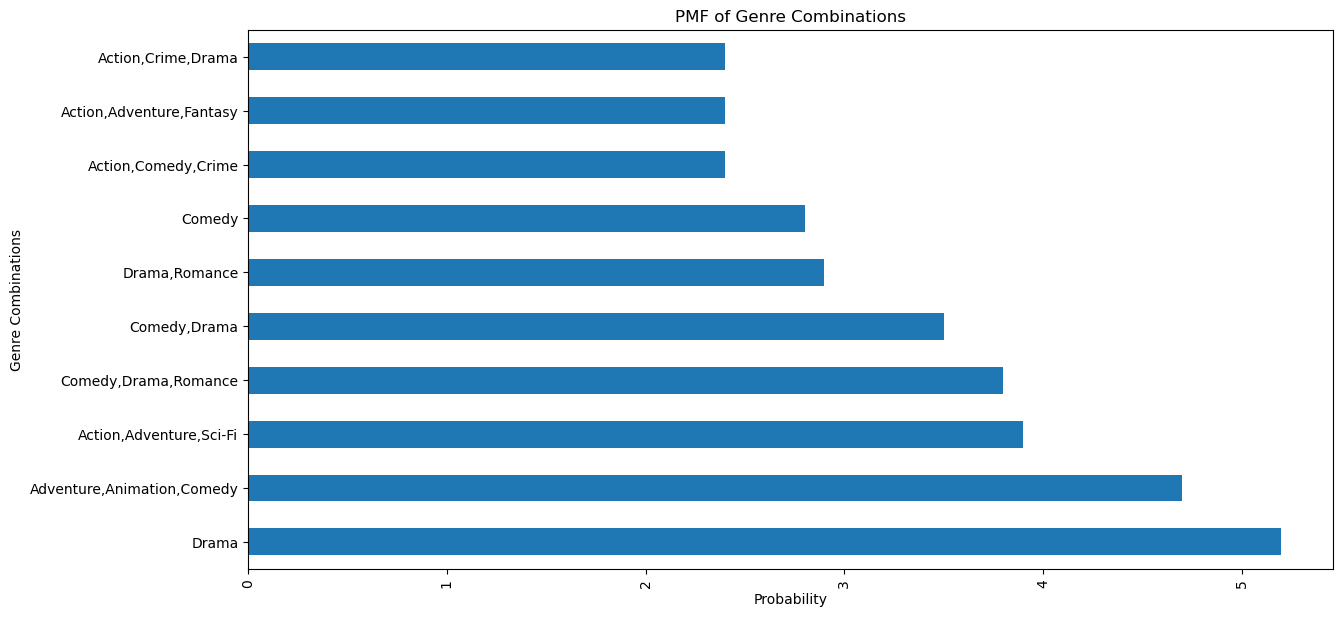

In [108]:
genre_counts = genre_counts.head(10)
pmf = genre_counts /10

plt.figure(figsize=(14, 7))
pmf.plot(kind='barh')
plt.title('PMF of Genre Combinations')
plt.ylabel('Genre Combinations')
plt.xlabel('Probability')
plt.xticks(rotation=90)
plt.show()

A profitable film has a high probability of 5.2 being a **Drama** film than any other genre.

In [75]:
# Use the Kolmogorov-Smirnov Test to check if final_movie_df represents the population data we just cleaned

from scipy.stats import ks_2samp # import the stats module for K-S test

statistic, p_value = ks_2samp(the_numbers_df['profit'], final_movie_df['gross_profit'])
print(f"K-S Statistic: {statistic}, P-Value: {p_value}")

K-S Statistic: 0.20441729216102475, P-Value: 1.2464718063894834e-33


In [76]:
from scipy.stats import chi2_contingency

# Example data for demonstration

# 1. Calculate observed frequencies in final_movie_df
observed_freq = final_movie_df['genres'].value_counts()

# 2. Calculate expected frequencies based on the_numbers_df proportions
total_genres = imdb_df['genres'].value_counts()
expected_freq = total_genres * (len(final_movie_df) / len(imdb_df))

# 3. Chi-Square Test of Goodness of Fit
chi2_stat, p_value, _, _ = chi2_contingency([observed_freq, expected_freq])

print(f"Chi-Square Statistic: {chi2_stat}, P-Value: {p_value}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

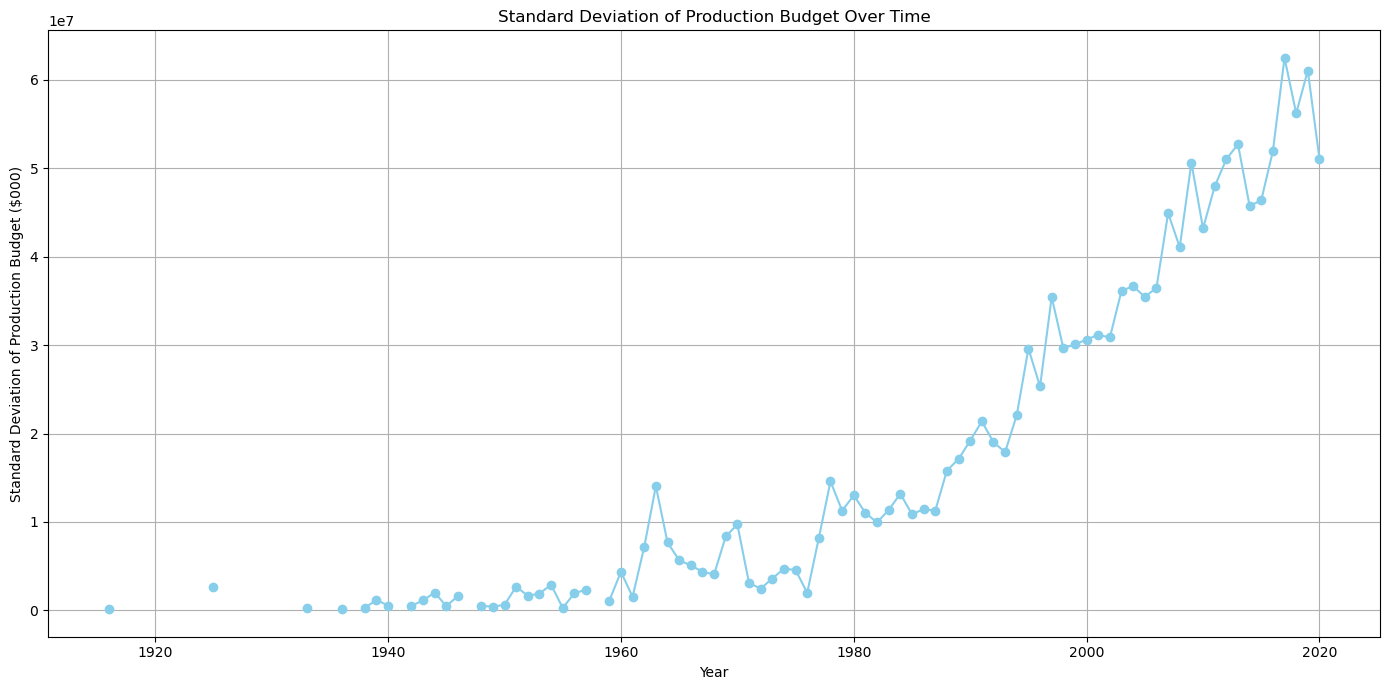

In [73]:

# Calculate the standard deviation of the production budget per year
std_dev_per_year = the_numbers_df.groupby('year')['production_budget'].std()

# Plotting the standard deviation over time
plt.figure(figsize=(14, 7))
plt.plot(std_dev_per_year.index, std_dev_per_year.values, marker='o', linestyle='-', color='skyblue')
plt.title('Standard Deviation of Production Budget Over Time')
plt.xlabel('Year')
plt.ylabel('Standard Deviation of Production Budget ($000)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Use Statistical Test To Check The Significance Of Our Cleaned Data

## The Three Buisness Questions

Returning to the three buisness questions we needed answered i.e

1. What Genres Are Most Profitable?
2. Does Release Date Influence Opening Weekend Box Office Success?
3. Which the directors have the highest success rate?



### What Genres Are Most Profitable? 

From the visualisation below we can see combination of either action or adventure or both genres have the highest gross profit. When elements of Drama, Comedy or science fiction are added to this combination it increases the chances of making greater margins. So if there were to be three combinations our film buisness should invest in it would be:
- **Action, Drama, Adventure**
- **Adventure, Sci-Fi, Action**
- **Adventure, Comedy, Action**

Documentary, Biography, History and Sport are not replicable since content itself may not be copyrighted (facts and historical events are in the public domain thus are not considered original video content in this context.

In [ ]:
profit_genres_mean = final_movie_df[['genres','gross_profit']].groupby(['genres']).agg(['count','mean', 'median'])
profit_genres_mean.sort_values(by=('gross_profit','count'), ascending=False).head(20)

In [ ]:
# Visulaise the average profit per genre combination
genre_profit = final_movie_df.groupby('genres')['gross_profit'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(14, 10))
bars = plt.barh(genre_profit.index, genre_profit.values, color='skyblue')
plt.xlabel('Profit ($00000000)')
plt.title('Profit by Genre')
plt.tight_layout()
plt.show()

### Does Release Date Influence Opening Weekend Box Office Success?
Studios release movies  based on particular holidays and months in order to target the overall sentiments. This means some months have higher revenue generation than other months. The visualisation below illustrates five months that have high profits, namely:
- **May**
- **June**
- **July**
- **November**
- **December**

It would be advisable to the buisness to consider timing it's releases around these months for better returns.

In [ ]:
average_profit_per_month = final_movie_df.groupby('release_month')['gross_profit'].mean()

# Plotting the average profit per month
plt.figure(figsize=(14, 7))
plt.plot(average_profit_per_month.index, average_profit_per_month.values, label='Average Profit', marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Profit ($)')
plt.title('Average Monthly Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To specify the release day's of the month with most gross profit, below is an additional visualization for this variable. The most successful realease day is usually on the **3rd of the month** as shown.

In [ ]:
average_profit_per_date = final_movie_df.groupby('release_day')['gross_profit'].mean()

# Plotting the average profit per month
plt.figure(figsize=(14, 7))
plt.plot(average_profit_per_date.index, average_profit_per_date.values, label='Average Profit', marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Profit ($)')
plt.title('Average Date Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Which directors have the highest success rate?
Based on experience and mean gross profit the top five directors the new buisness stakeholders can trust with a big budget film are:
- **Steven Spielberg**
- **Clint Eastwood**
- **Francis Lawrence**
- **Jon M. Chu**
- **Tim Story**

These directors have consistent profitability in the projects they undertake despite not having the highest grossing films of all time.

In [ ]:
profit_directors_mean = final_movie_df[['director','gross_profit']].groupby(['director']).agg(['count','mean', 'median'])
profit_directors_mean.sort_values(by=('gross_profit','count'), ascending=False).head(20)

In [ ]:
directors_profit = final_movie_df.groupby('director')['gross_profit'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(14, 10))
bars = plt.barh(directors_profit.index, directors_profit.values, color='darkblue')
plt.xlabel('Profit ($00000000)')
plt.title('Profit by Genre')
plt.tight_layout()
plt.show()

### Profit Projections For Future Years

In addition to showing the best course of action when starting a film buisness, it would be prudent to have a projection of the market based on available data to provide insight on whether the trend is favourable.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example data
# final_movie_df = pd.read_csv('your_data.csv')  # Load your data here

# Prepare feature columns and target variable
features = ['production_budget', 'year', 'genres', 'director', 'averagerating', 'release_month', 'release_day']
target = 'gross_profit'

# Define numerical and categorical features
numerical_features = ['production_budget', 'year', 'averagerating']
categorical_features = ['genres', 'director', 'release_month', 'release_day']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Prepare Data for Regression
X = final_movie_df[features]
y = final_movie_df[target]

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R^2: {r2}')

# Print model coefficients
feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out())
)
coefficients = pd.DataFrame(model.coef_, feature_names, columns=['Coefficient'])
coefficients

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Sample DataFrame (Replace with your actual DataFrame)
final_movie_df = pd.DataFrame({
    'production_budget': np.random.randint(1e7, 1e8, 1000),
    'year': np.random.randint(2000, 2024, 1000),
    'averagerating': np.random.uniform(1, 10, 1000),
    'genres': np.random.choice(['Action,Drama,Adventure', 'Adventure,Sci-Fi,Action', 'Adventure,Fantasy,Action', 'Other'], 1000),
    'director': np.random.choice(['Steven Spielberg', 'Clint Eastwood', 'Francis Lawrence', 'Jon M. Chu', 'Tim Story', 'Other'], 1000),
    'release_month': np.random.choice(['May', 'June', 'July', 'November', 'December', 'Other'], 1000),
    'gross_profit': np.random.uniform(1e7, 1e8, 1000)
})

# Encode categorical variables
final_movie_df = pd.get_dummies(final_movie_df, columns=['genres', 'director', 'release_month'], drop_first=True)

# Normalize numerical features
numerical_features = ['production_budget', 'year', 'averagerating']
scaler = StandardScaler()
final_movie_df[numerical_features] = scaler.fit_transform(final_movie_df[numerical_features])

# Prepare Data for Regression
X = final_movie_df[['production_budget', 'year', 'averagerating'] + 
                    [col for col in final_movie_df.columns if col.startswith('genres_')] + 
                    [col for col in final_movie_df.columns if col.startswith('director_')] + 
                    [col for col in final_movie_df.columns if col.startswith('release_month_')]]
y = final_movie_df['gross_profit']

# Fit the Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# Define combinations, top directors, and high-profit months
genre_combinations = ['Action,Drama,Adventure', 'Adventure,Sci-Fi,Action', 'Adventure,Fantasy,Action']
top_directors = ['Steven Spielberg', 'Clint Eastwood', 'Francis Lawrence', 'Jon M. Chu', 'Tim Story']
high_profit_months = ['May', 'June', 'July', 'November', 'December']

# Create a DataFrame for projections
projections = []

for genre in genre_combinations:
    for director in top_directors:
        for month in high_profit_months:
            # Create a new row for prediction
            new_row = {
                'production_budget': [1],  # Adjust as needed
                'year': [2024],  # Adjust as needed
                'averagerating': [7],  # Adjust as needed
            }
            
            # Add genre, director, and month columns
            for g in final_movie_df.columns:
                if g.startswith('genres_'):
                    new_row[g] = [1 if genre in g else 0]
                elif g.startswith('director_'):
                    new_row[g] = [1 if director in g else 0]
                elif g.startswith('release_month_'):
                    new_row[g] = [1 if month in g else 0]
            
            # Convert to DataFrame
            new_df = pd.DataFrame(new_row)
            new_df[numerical_features] = scaler.transform(new_df[numerical_features])
            
            # Predict the gross profit
            predicted_profit = model.predict(new_df)[0]
            projections.append({
                'Genre Combination': genre,
                'Director': director,
                'Month': month,
                'Predicted Gross Profit': predicted_profit
            })

# Convert projections to DataFrame
projections_df = pd.DataFrame(projections)

# Visualization using seaborn
plt.figure(figsize=(14, 7))

# Plot projections by genre and director
sns.barplot(data=projections_df, x='Genre Combination', y='Predicted Gross Profit', hue='Director', palette='viridis')

plt.xlabel('Genre Combination')
plt.ylabel('Predicted Gross Profit ($)')
plt.title('Projected Gross Profit by Genre Combination and Director')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Director')
plt.tight_layout()
plt.show()

# Plot average gross profit for high-profit months
monthly_profit_avg = final_movie_df[final_movie_df.filter(like='release_month_').columns].copy()
monthly_profit_avg['gross_profit'] = final_movie_df['gross_profit']

# Aggregate by month
monthly_profit_avg = final_movie_df.groupby(
    [col for col in final_movie_df.columns if col.startswith('release_month_')]
)['gross_profit'].mean().reset_index()

# Melt the DataFrame for better visualization
monthly_profit_avg = monthly_profit_avg.melt(id_vars=['gross_profit'], var_name='Month', value_name='Average Gross Profit')

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_profit_avg, x='Month', y='Average Gross Profit', palette='coolwarm')

plt.xlabel('Month')
plt.ylabel('Average Gross Profit ($)')
plt.title('Average Gross Profit by Month')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
